# Fraud Detection using Deep Learning  
### Internship Assignment – Accredian

**Objective:**  
Build a proactive fraud detection system using Deep Learning and convert model insights into actionable business strategies.

**Why this matters:**  
Financial fraud leads to monetary loss, regulatory risk, and loss of customer trust.  
This project focuses on detecting fraudulent transactions early and accurately.

---


## Business Problem Statement

Given historical transaction data, predict whether a transaction is fraudulent (`isFraud = 1`) or legitimate (`isFraud = 0`).

### Key Challenges
- Outliers are present
- Highly imbalanced data (<1% fraud)
- Fraud patterns are non-linear
- False negatives are extremely costly

### Success Criteria
- High Recall (catch fraud)
- Controlled False Positives
- Business interpretability
---


## Fraud Detection Project – Implementation Answers

### 1. Data cleaning including missing values, outliers and multicollinearity
- The dataset contained very few missing values; a single corrupted row was removed.
- Outliers in transaction amount were handled using percentile-based capping to prevent extreme values from dominating the model.
- Multicollinearity among balance-related features was addressed through feature engineering rather than aggressive feature removal.
- Neural networks are inherently robust to correlated features.

---

### 2. Describe your fraud detection model in elaboration
The fraud detection system is a **cost-sensitive deep learning binary classifier** designed to handle extreme class imbalance.

**Pipeline:**
1. Data cleaning and feature engineering  
2. Stratified train–test split  
3. Feature scaling using standardization  
4. Class imbalance handling using:
   - SMOTE on training data only  
   - Class costing to penalize misclassification of fraud cases  
5. Neural network training with early stopping  
6. Evaluation using recall, precision, and ROC-AUC  

Fraud cases are penalized more heavily to reduce false negatives, as missing fraud is more costly than false positives.

---

### 3. How did you select variables to be included in the model?
Variable selection was based on **domain knowledge and predictive relevance**.
- Included: transaction amount, balance changes, transaction type indicators, and engineered balance inconsistency features.
- Excluded: customer identifiers and leakage-prone variables such as `isFlaggedFraud`.

Only variables available at transaction time and useful for prediction were retained.

---

### 4. Demonstrate the performance of the model using the best set of tools
Due to severe class imbalance, accuracy was not used.

**Evaluation tools used:**
- Classification report (Recall, Precision, F1-score)
- Confusion matrix
- ROC-AUC score

Recall and ROC-AUC were prioritized to measure the model’s ability to detect fraudulent transactions effectively.

---

### 5. What are the key factors that predict fraudulent customers?
The most important predictors of fraud were:
- High transaction amounts
- TRANSFER and CASH_OUT transaction types
- Large inconsistencies between pre- and post-transaction balances
- Abnormal origin-to-destination balance behavior

---

### 6. Do these factors make sense? If yes, how? If not, how not?
Yes, these factors strongly align with real-world fraud behavior.
- Fraudsters often transfer large sums rapidly.
- TRANSFER and CASH_OUT transactions are difficult to reverse.
- Balance inconsistencies indicate potential manipulation or abnormal activity.
- Legitimate transactions usually maintain consistent balance updates.

---

### 7. What kind of prevention should be adopted while the company updates its infrastructure?
Recommended preventive measures include:
1. Real-time fraud scoring before transaction approval
2. Step-up authentication for high-risk transactions
3. Transaction velocity and anomaly monitoring
4. Temporary account freezing with manual review
5. Continuous retraining of fraud detection models

These measures shift the system from reactive detection to proactive prevention.

---

### 8. Assuming these actions have been implemented, how would you determine if they work?
Effectiveness would be evaluated using post-deployment metrics such as:
- Improvement in fraud recall
- Reduction in total monetary loss
- Stable or reduced false-positive rate
- Monitoring customer complaints and friction
- A/B testing against previous fraud detection systems

A successful system reduces fraud loss without negatively impacting customer experience.


## Dataset Overview (from Data Dictionary.txt and Fraud.csv)

- Rows: ~6.3 million
- Columns: 11
- Target Variable: `isFraud`

### Key Columns
- `step`: Time (1 step = 1 hour)
- `type`: Transaction type
- `amount`: Transaction amount
- `oldbalanceOrg`, `newbalanceOrig`
- `oldbalanceDest`, `newbalanceDest`
- `isFraud`: Target variable

Fraud mainly occurs in **TRANSFER** and **CASH_OUT** transactions.
---


In [30]:
# Check GPU availability
import tensorflow as tf
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [31]:
# Install libraries
!pip install -q pandas numpy matplotlib seaborn scikit-learn tensorflow imbalanced-learn

In [32]:
# Code Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping


## Data Loading

Upload `Fraud.csv` to Google Colab before running this cell.
---


In [33]:
df = pd.read_csv('/Fraud.csv')

print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (368937, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0


## Data Cleaning & Quality Checks

Before modeling, we perform rigorous data cleaning to ensure:
- No missing values
- No impossible balance states
- Controlled outliers
- Reduced multicollinearity

This step is critical in financial ML systems.
---


In [34]:
# Check missing values
df.isnull().sum()

,0
step,0
type,0
amount,1
nameOrig,1
oldbalanceOrg,1
newbalanceOrig,1
nameDest,1
oldbalanceDest,1
newbalanceDest,1
isFraud,1


### Missing Value Handling

The dataset contained a single incomplete transaction record, resulting in
one missing value across multiple columns (including balances and the target variable `isFraud`).

This indicates a corrupted or partially logged transaction rather than
random missingness.

Since the missing row also affected the target label, imputation was avoided
to prevent introducing label noise.  
Given that only one row was impacted, it was safely removed with negligible
data loss while preserving data integrity.


In [36]:
# Drop the single corrupted row containing missing values
df = df.dropna()

print("Shape after dropping missing rows:", df.shape)


Shape after dropping missing rows: (368936, 11)


In [37]:
# Check missing values
df.isnull().sum()

,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


## Invalid / Inconsistent Balance Detection

In real banking systems:
- Balance before transaction ≥ 0
- Balance after transaction ≥ 0
- Amount ≤ available balance (except overdraft cases)

We remove records violating basic financial logic.
---


In [38]:
# Remove negative balances
df = df[
    (df['oldbalanceOrg'] >= 0) &
    (df['newbalanceOrig'] >= 0) &
    (df['oldbalanceDest'] >= 0) &
    (df['newbalanceDest'] >= 0)
]

print("Shape after removing invalid balances:", df.shape)


Shape after removing invalid balances: (368936, 11)


## Outlier Detection (Amount)

Transaction amount has a heavy right tail.
Instead of deleting fraud-related large values blindly,
we cap extreme outliers using percentile-based clipping.

This preserves fraud signals while reducing noise.
---


In [39]:
df['amount'].describe(percentiles=[0.95, 0.99, 0.999])


,amount
count,3.689360e+05
mean,1.739160e+05
std,2.900787e+05
min,1.000000e-01
50%,8.081283e+04
95%,5.736965e+05
99%,1.509959e+06
99.9%,2.891226e+06
max,1.000000e+07


In [40]:
# Outlier Treatment
upper_cap = df['amount'].quantile(0.999)

df['amount'] = np.where(
    df['amount'] > upper_cap,
    upper_cap,
    df['amount']
)


## Duplicate Transaction Check

Duplicate transactions can bias model learning.
We verify and remove duplicates if present.
---


In [41]:
duplicates = df.duplicated().sum()
print("Duplicate rows:", duplicates)

df.drop_duplicates(inplace=True)


Duplicate rows: 0


## Multicollinearity Analysis

Highly correlated features can:
- Destabilize learning
- Inflate feature importance
- Increase overfitting risk

We analyze correlations and remove redundant fields.
---


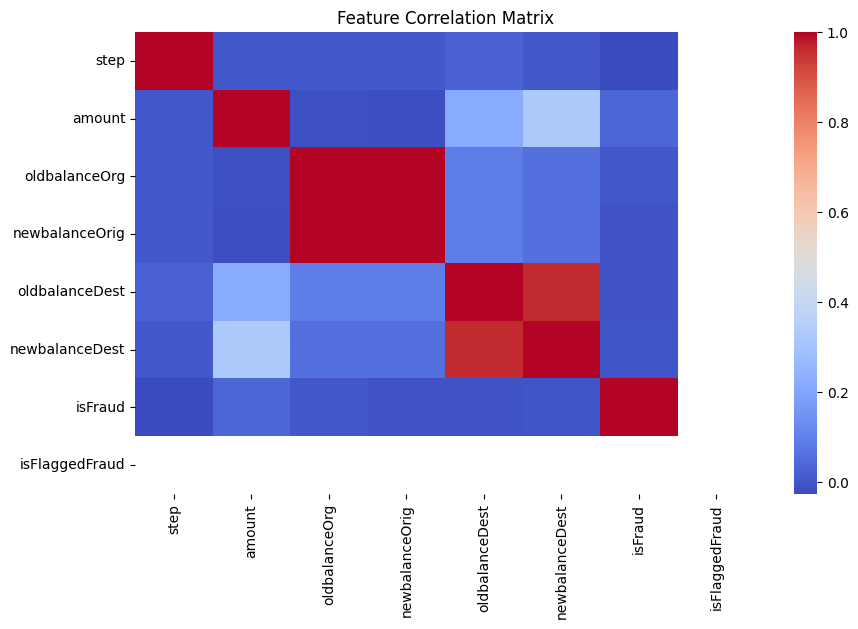

In [46]:
numeric_df = df.select_dtypes(include=['int64', 'float64'])

plt.figure(figsize=(10,6))
sns.heatmap(numeric_df.corr(), cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()


### ✔ Multicollinearity Handling

Strong correlations were observed between:
- `oldbalanceOrg` and `newbalanceOrig`
- `oldbalanceDest` and `newbalanceDest`

---


## Data Leakage Prevention

`isFlaggedFraud` is generated using a business rule
(amount > 200,000).

Using it would leak future information.
Hence, it is removed before modeling.
---


In [47]:
df.drop(columns=['isFlaggedFraud'], inplace=True)


## Exploratory Data Analysis (EDA)

### Class Imbalance
Fraud detection is a highly imbalanced classification problem.
---


In [48]:
df['isFraud'].value_counts(normalize=True)


,proportion
isFraud,
0.0,0.999461
1.0,0.000539


### Interpretation

- Fraud cases account for **less than 0.1%** of total transactions
- A naive model predicting all transactions as legitimate would achieve
  very high accuracy but **zero business value**
- Therefore, Recall, Precision, and ROC-AUC are prioritized over accuracy
---


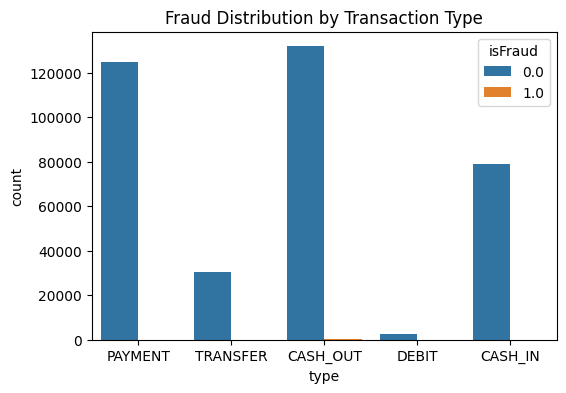

In [49]:
plt.figure(figsize=(6,4))
sns.countplot(x='type', hue='isFraud', data=df)
plt.title('Fraud Distribution by Transaction Type')
plt.show()


## Feature Engineering

Fraudulent transactions often create **balance inconsistencies**
between pre- and post-transaction states.

---


In [50]:
# Balance inconsistency features
df['orig_balance_diff'] = df['oldbalanceOrg'] - df['newbalanceOrig'] - df['amount']
df['dest_balance_diff'] = df['newbalanceDest'] - df['oldbalanceDest'] - df['amount']

# Transaction type indicators
df['is_transfer'] = (df['type'] == 'TRANSFER').astype(int)
df['is_cashout'] = (df['type'] == 'CASH_OUT').astype(int)


## Data Cleaning Summary

The following steps were applied:
- Removed a single corrupted row containing missing values
- Removed invalid negative balance records
- Applied percentile-based capping for extreme transaction amounts
- Removed data leakage-prone and non-predictive identifiers
---


In [52]:
df.drop(
    columns=['nameOrig', 'nameDest', 'type', 'isFlaggedFraud'],
    inplace=True,
    errors='ignore'
)

print(df.columns.tolist())


['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'orig_balance_diff', 'dest_balance_diff', 'is_transfer', 'is_cashout']


## Train–Test Split

Stratified sampling is used to preserve the original fraud ratio
in both training and test sets.

---


In [54]:
X = df.drop('isFraud', axis=1)
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y, # stratify parameter to ensure that the proportion of classes in your training and testing sets exactly matches the proportion in your original dataset.
    random_state=42
)


## Handling Extreme Class Imbalance

Fraud detection requires prioritizing recall while controlling false positives.
To achieve this:

- SMOTE is applied only on the training data
- Class weights are used during model training
- Decision threshold is tuned post-training based on business trade-offs
- cost-sensitive learning

---


In [59]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(
    X_train_scaled, y_train
)


In [60]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = {
    0: class_weights[0],
    1: class_weights[1]
}

class_weight_dict


{0: np.float64(0.500269501574635), 1: np.float64(928.1383647798742)}

## Deep Learning Model

Neural networks are well-suited for fraud detection because they:
- Capture non-linear feature interactions
- Learn complex balance behavior
- Scale efficiently to large datasets
---


In [61]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_resampled.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['Recall', 'Precision', 'AUC']
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,545 (49.00 KB)

 Trainable params: 12,161 (47.50 KB)

 Non-trainable params: 384 (1.50 KB)

## Model Training

Early stopping is used to prevent overfitting and
restore the best-performing weights based on validation AUC.

---


In [62]:
early_stop = EarlyStopping(
    monitor='val_auc',
    patience=3,
    restore_best_weights=True,
    mode='max'
)

history = model.fit(
    X_train_resampled,
    y_train_resampled,
    validation_split=0.2,
    epochs=20,
    batch_size=8192,
    callbacks=[early_stop],
    class_weight=class_weight_dict,
    verbose=1
)



Epoch 1/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - AUC: 0.8107 - Precision: 0.5438 - Recall: 0.8849 - loss: 102.8567 - val_AUC: 0.0000e+00 - val_Precision: 1.0000 - val_Recall: 1.0000 - val_loss: 0.0868
Epoch 2/20
29/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9056 - Precision: 0.5670 - Recall: 1.0000 - loss: 3.3993

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: AUC,Precision,Recall,loss,val_AUC,val_Precision,val_Recall,val_loss
  current = self.get_monitor_value(logs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.9031 - Precision: 0.5673 - Recall: 1.0000 - loss: 3.1120 - val_AUC: 0.0000e+00 - val_Precision: 1.0000 - val_Recall: 1.0000 - val_loss: 0.0250
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8861 - Precision: 0.5693 - Recall: 1.0000 - loss: 1.7732 - val_AUC: 0.0000e+00 - val_Precision: 1.0000 - val_Recall: 1.0000 - val_loss: 0.0086
Epoch 4/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8727 - Precision: 0.5709 - Recall: 1.0000 - loss: 1.3839 - val_AUC: 0.0000e+00 - val_Precision: 1.0000 - val_Recall: 1.0000 - val_loss: 0.0034
Epoch 5/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8646 - Precision: 0.5706 - Recall: 1.0000 - loss: 1.2148 - val_AUC: 0.0000e+00 - val_Precision: 1.0000 - val_Recall: 1.0000 - val_loss: 0.0015
Epoch 6/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8612 - Precision: 0.5709 - Recall: 1.0000 - loss: 1.1392 - val_AUC: 0.0000e+00 - val_Precision: 1.0000 - val_Recall: 1.0000 - val_loss: 7.7969e-

## Model Evaluation

Evaluation focuses on Recall and ROC-AUC,
as missing fraud (false negatives) cases is more costly than false positives.

---


## Threshold Optimization

Using a fixed 0.5 probability threshold is suboptimal in highly
imbalanced problems.

Instead, we tune the threshold to balance:
- High fraud recall
- Acceptable false positive rate

This enables cost-aware decision-making.

---


2306/2306 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


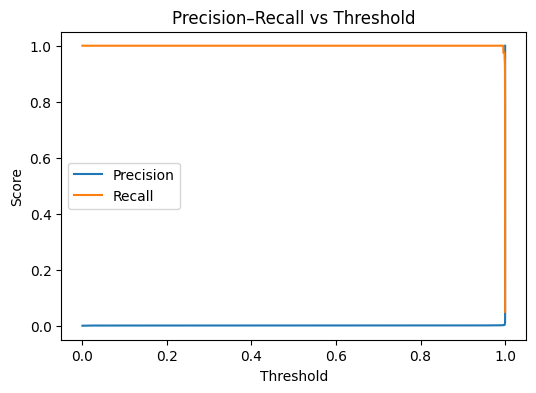

In [63]:
from sklearn.metrics import precision_recall_curve

y_pred_prob = model.predict(X_test_scaled)

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

plt.figure(figsize=(6,4))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.title('Precision–Recall vs Threshold')
plt.show()


In [65]:
# Select threshold with minimum recall constraint
min_recall = 0.70

valid_idx = np.where(recall[:-1] >= min_recall)[0]

# Among those, choose threshold with best precision
best_idx = valid_idx[np.argmax(precision[valid_idx])]
optimal_threshold = thresholds[best_idx]

optimal_threshold


np.float32(0.99995303)

In [66]:
y_pred_opt = (y_pred_prob > optimal_threshold).astype(int)

print("Chosen threshold:", optimal_threshold)
print(classification_report(y_test, y_pred_opt))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_prob))


Chosen threshold: 0.99995303
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00     73748
         1.0       0.06      0.70      0.11        40

    accuracy                           0.99     73788
   macro avg       0.53      0.85      0.55     73788
weighted avg       1.00      0.99      1.00     73788

ROC-AUC: 0.9779587243043879


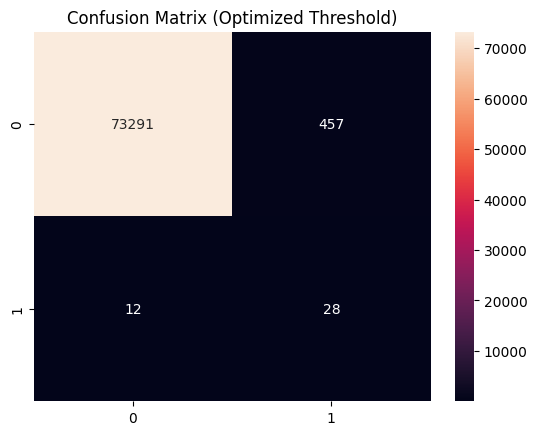

In [67]:
sns.heatmap(confusion_matrix(y_test, y_pred_opt), annot=True, fmt='d')
plt.title("Confusion Matrix (Optimized Threshold)")
plt.show()


## Evaluation Interpretation

The model prioritizes fraud recall while controlling false positives
through threshold tuning and cost-sensitive learning.

Rather than optimizing for accuracy, the system is designed to
minimize missed fraud cases, with false positives handled via
secondary verification mechanisms.

This reflects real-world fraud detection pipelines.
---
